In [354]:
# SECTION I: OVERVIEW DATA
import pandas as pd
# SECTION II: CLEANING 
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
# SECTION III: TEXT VECTORISATION/MACCHINE LEARING MODEL/HYPER-PARAMETER.
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
# SECTION VI: MODEL EXTRAS
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# SECTION V: EXTRAS VISUALISATION
from wordcloud import WordCloud
# WORD COUNT
import json

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/liliamarzougui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/liliamarzougui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/liliamarzougui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/liliamarzougui/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# SECTION I: OVERVIEW DATA 
***
The four cells provided useful insights for dataset cleaning.
***

In [355]:
# read the training data from train.tsv file
X_train = pd.read_csv("train.tsv",quoting = 3, delimiter = "\t", header= 0)#[1]

X_test = pd.read_csv("dev.tsv", quoting = 3, delimiter = "\t", header = 0)

In [356]:
X_train 

,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0
...,...,...
67344,a delightful comedy,1
67345,"anguish , anger and frustration",0
67346,"at achieving the modest , crowd-pleasing goals...",1
67347,a patient viewer,1


In [357]:
X_test 

,sentence,label
0,it 's a charming and often affecting journey .,1
1,unflinchingly bleak and desperate,0
2,allows us to hope that nolan is poised to emba...,1
3,"the acting , costumes , music , cinematography...",1
4,"it 's slow -- very , very slow .",0
...,...,...
867,has all the depth of a wading pool .,0
868,a movie with a real anarchic flair .,1
869,a subject like this should inspire reaction in...,0
870,... is an arthritic attempt at directing by ca...,0


# SECTION II: CLEANING
***
Cleaning a dataset it is crucial since data can contain irrelevant information, which negatively impacts the model.
***

In [358]:
def cleaning(sentence):
    
    # Remove punctuation marks
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))#[1]
    
    # Tokenize the sentence: used to split a sentence into individual words
    words = word_tokenize(sentence)
    
    # Remove stop words
    stop_words = set(stopwords.words('english')) #[2]
    words = [word for word in words if word.lower() not in stop_words]
    
    # Lemmatize the words (e.g. "running" and "ran")
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words] #[2]
    
    # Join the words to form a cleaned sentence
    cleaned_sentence = ' '.join(words)
    
    return cleaned_sentence

df_train = X_train['sentence'].apply(cleaning)
df_test = X_test['sentence'].apply(cleaning) #[3]

In [359]:
#Creates a new pandas DataFrame df_train 
df_train = pd.DataFrame(df_train) 

#Creates a new column named 'sentiment' in df_train and assigns the values from the label column of the X_train DataFrame to it.
df_train['sentiment'] = X_train['label'] 
df_train

,sentence,sentiment
0,hide new secretion parental unit,0
1,contains wit labored gag,0
2,love character communicates something rather b...,1
3,remains utterly satisfied remain throughout,0
4,worst revengeofthenerds clichés filmmaker coul...,0
...,...,...
67344,delightful comedy,1
67345,anguish anger frustration,0
67346,achieving modest crowdpleasing goal set,1
67347,patient viewer,1


In [360]:
df_test = pd.DataFrame(df_test)  
df_test['sentiment']=X_train['label']
df_test

,sentence,sentiment
0,charming often affecting journey,0
1,unflinchingly bleak desperate,0
2,allows u hope nolan poised embark major career...,1
3,acting costume music cinematography sound asto...,0
4,slow slow,0
...,...,...
867,depth wading pool,0
868,movie real anarchic flair,0
869,subject like inspire reaction audience pianist,0
870,arthritic attempt directing callie khouri,0


# SECTION III: TEXT VECTORISATION/MACCHINE LEARING MODEL/HYPER-PARAMETER.
***
In this section: 

## a)The text vectorisation method of choice:

1. HashingVectorizer converts the text data into a fixed-length vector of integers, it rappresent vector will represent the occurrence of words in the text document and can be used as input for machine learning models. #[1]

2. TfidfVectorizer will apply the TF-IDF transformation to the text data and convert it into a matrix of TF-IDF features. There are many TF-IDF features, it is upon the case; i.e ngram_range(2,2). So, the matrix will be in biagram format. The TF-IDF features can then be used as input for machine learning models. #[2]

3. CountVectorizer will tokenize the text data by splitting it into individual words (tokens) and count the frequency of each token in each document. It then constructs a sparse matrix of document-term counts, where each row represents a document, and each column represents a unique token. This matrix can be used as input for machine learning models. #[3]

###### As note, vectorizer methods are used to convert input text data into a numerical format that can be easily processed by machine learning algorithms. 

## b) The machine learning model of choice:

1. Logistic Regression is a linear classification algorithm that estimates the probability of an event occurring based on linear relationship. #[4]

2. Naive Bayes Multinomial is a probabilistic classification algorithm. It models the likelihood of each input feature given the class label and estimates the class probabilities using Bayes' theorem. #[5]

3. Random Forest is an ensemble learning algorithm that trains a multitude of decision trees on different random subsets of the input features and data samples and aggregates their predictions to make the final decision. #[6]

## c)The hyper parmaters of choice:

- ngram_range is used in the CountVectorizer and HashingVectorizer to specify the range of n-grams to use for text feature extraction. #[1], [2]

- max_iter is used in the logistic regression algorithm to specify the maximum number of iterations for the optimization algorithm to converge. #[4]

- penalty is used in the logistic regression algorithm to specify the type of regularization penalty to use. #[4]

- solver is used in the logistic regression algorithm to specify the solver to use for the optimization problem. #[4]

- n_features is used in the HashingVectorizer to specify the number of features to use for text feature extraction. #[1]

- nb__alpha is used in the Naive Bayes classifier to specify the smoothing parameter for the Laplace smoothing technique. #[5]

- n_estimators is used in the Random Forest classifier to specify the number of decision trees to build in the forest. #[6]


###### As a side note: the techniques used to implement hyperparameters were of two types: manual, meaning I selected the hyperparameters myself, or with GridSearch, meaning I chose a set and GridSearch selected the best ones.


We will explore these models with different hyperparameters and vectorization techniques to determine the optimal approach a sentiment analysis. Additionally, we will evaluate the performance of these models using the classification_report function, and compare the outcome. 
***

# SECTION III: TEXT VECTORISATION/MACCHINE LEARING MODEL/HYPER-PARAMETER.

In [361]:
# Logistic regression with CountVectorizer.

In [362]:
# Define the pipeline 
Logistic_Regression_Counter_1 = Pipeline([
    ('counter', CountVectorizer(ngram_range=(1, 2))),#for the gadgets look Skilearn. I learn it from .head(1), parathesis you can insert gadgets.
    ('lr', LogisticRegression(max_iter=1000,
                              penalty='l2',
                              solver='lbfgs'))
]) #[2] but I saw in many.

In [363]:
# Target data 
X_train_1, y_train_1 = df_train['sentence'], df_train['sentiment']
X_test_1, y_test_1 = df_test['sentence'], df_test['sentiment'] 

In [364]:
# Fit the model with the training data
Logistic_Regression_Counter_1.fit(X_train_1,
                                  y_train_1) #[1]

Pipeline(steps=[('counter', CountVectorizer(ngram_range=(1, 2))),
                ('lr', LogisticRegression(max_iter=1000))])

In [365]:
# Predict the sentiment sentence as vector on the test set. #[1]
y_pred_Logistic_Regression_Counter_1 = Logistic_Regression_Counter_1.predict(X_test_1)
y_pred_Logistic_Regression_Counter_1

array([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,

In [366]:
# Print the train and test accuracy.
print('Logistic regression with CountVectorizer:')

print('Train score:', Logistic_Regression_Counter_1.score(X_train_1,
                                                          y_train_1)) #[1]

print('Test score:', Logistic_Regression_Counter_1.score(X_test_1,
                                                         y_test_1))

Logistic regression with CountVectorizer:
Train score: 0.970719684033913
Test score: 0.5240825688073395


In [367]:
# Evaluate the performance of the model on the test set.
print('Logistic regression with CountVectorizer classification report:')
print(classification_report(y_test_1, y_pred_Logistic_Regression_Counter_1)) #[1]

Logistic regression with CountVectorizer classification report:
              precision    recall  f1-score   support

           0       0.49      0.44      0.46       406
           1       0.55      0.59      0.57       466

    accuracy                           0.52       872
   macro avg       0.52      0.52      0.52       872
weighted avg       0.52      0.52      0.52       872



In [368]:
#Pipiline
#Target
#Fit 
#Predict 
#Scores
#Classification 

In [369]:
# Logistic regression with TfidfVectorizer

In [370]:
Logistic_Regression_Tfidf_2 = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))), #From before, I only changed the vector.
    ('lr', LogisticRegression(max_iter=1000, 
                              penalty='l2',
                              solver='lbfgs'))
])

X_train_2, y_train_2 = df_train['sentence'], df_train['sentiment']
X_test_2, y_test_2 = df_test['sentence'], df_test['sentiment']

Logistic_Regression_Tfidf_2.fit(X_train_2,
                                y_train_2)

y_pred_Logistic_Regression_Tfidf_2 = Logistic_Regression_Tfidf_2.predict(X_test_2)

print('Logistic regression with TfidfVectorizer:')
print('Train score:', Logistic_Regression_Tfidf_2.score(X_train_2, y_train_2))
print('Test score:', Logistic_Regression_Tfidf_2.score(X_test_2, y_test_2))
print('Logistic regression with TfidfVectorizer classification report::')
print(classification_report(y_test_2, y_pred_Logistic_Regression_Tfidf_2))

Logistic regression with TfidfVectorizer:
Train score: 0.9511351319247502
Test score: 0.5126146788990825
Logistic regression with TfidfVectorizer classification report::
              precision    recall  f1-score   support

           0       0.47      0.42      0.44       406
           1       0.54      0.59      0.57       466

    accuracy                           0.51       872
   macro avg       0.51      0.51      0.51       872
weighted avg       0.51      0.51      0.51       872



In [371]:
y_pred_Logistic_Regression_Tfidf_2

array([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,

In [372]:
# Logistic regression with HashingVectorizer

In [373]:
Logistic_Regression_Hashing_3 = Pipeline([
    ('vectorizer', HashingVectorizer(n_features=216)),
    ('lr', LogisticRegression(max_iter=1000, 
                              penalty='l2',
                              solver='lbfgs'))
])

X_train_3, y_train_3 = df_train['sentence'], df_train['sentiment']
X_test_3, y_test_3 = df_test['sentence'], df_test['sentiment']


Logistic_Regression_Hashing_3.fit(X_train_3,
                                  y_train_3)

y_pred_Logistic_Regression_Hashing_3 = Logistic_Regression_Hashing_3.predict(X_test_3)

print('Logistic regression with HashingVectorizer:')
print('Train score:', Logistic_Regression_Hashing_3.score(X_train_3, y_train_3))
print('Test score:', Logistic_Regression_Hashing_3.score(X_test_3, y_test_3))
print('Logistic regression with HashingVectorizer classification report:')
print(classification_report(y_test_3, y_pred_Logistic_Regression_Hashing_3))

Logistic regression with HashingVectorizer:
Train score: 0.635540245586423
Test score: 0.5149082568807339
Logistic regression with HashingVectorizer classification report:
              precision    recall  f1-score   support

           0       0.47      0.36      0.41       406
           1       0.54      0.65      0.59       466

    accuracy                           0.51       872
   macro avg       0.51      0.50      0.50       872
weighted avg       0.51      0.51      0.50       872



In [374]:
y_pred_Logistic_Regression_Hashing_3

array([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,

In [375]:
# Naive Bayes (Multinomial) with CountVectorizer GridSearch

#Pipiline
#Parameters
#GrindSearch
#Target
#Fit 
#Scores
#Predict
#Classification 

In [376]:
Naive_Bayes_Counter_4 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [377]:
Naive_Bayes_Counter_parameters_4 = {
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'nb__alpha': [1, 0.1, 0.01],
} #[4]

In [378]:
# Search for the best hyperparameters using cross-validation 
Naive_Bayes_Counter_4 = GridSearchCV(Naive_Bayes_Counter_4,
                                     Naive_Bayes_Counter_parameters_4, 
                                     cv = 10) #[3]

In [379]:
X_train_4, y_train_4 = df_train['sentence'], df_train['sentiment']
X_test_4, y_test_4 = df_test['sentence'], df_test['sentiment']

In [380]:
Naive_Bayes_Counter_4.fit(X_train_4, y_train_4)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__alpha': [1, 0.1, 0.01],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]})

In [381]:
train_score = Naive_Bayes_Counter_4.score(X_train_4,
                                          y_train_4)

test_score = Naive_Bayes_Counter_4.score(X_test_4,
                                         y_test_4)

In [382]:
# Predict the sentence on the test set using the best model found by GridSearchCV 
y_pred_Naive_Bayes_Counter_4 = Naive_Bayes_Counter_4.predict(X_test_4)

In [383]:
y_pred_Naive_Bayes_Counter_4

array([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,

In [384]:
# Print the best parameters found by GridSearchCV 
print('Naive Bayes (Multinomial) with CountVectorizer:')
print('Best parameters:', Naive_Bayes_Counter_4.best_params_) #[3]
print('Train score:', train_score)
print('Test score:', test_score)
print('Naive Bayes (Multinomial) with CountVectorizer classification report:')
print(classification_report(y_test_4, y_pred_Naive_Bayes_Counter_4))

Naive Bayes (Multinomial) with CountVectorizer:
Best parameters: {'nb__alpha': 1, 'vectorizer__ngram_range': (1, 2)}
Train score: 0.9213945270159913
Test score: 0.4988532110091743
Naive Bayes (Multinomial) with CountVectorizer classification report:
              precision    recall  f1-score   support

           0       0.46      0.44      0.45       406
           1       0.53      0.55      0.54       466

    accuracy                           0.50       872
   macro avg       0.49      0.49      0.49       872
weighted avg       0.50      0.50      0.50       872



In [385]:
# Naive Bayes (Multinomial) with CountVectorizer manually.

In [386]:
Naive_Bayes_counter_manually_5 = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2),
                                   max_features=5000)),
    ('nb', MultinomialNB(alpha=0.1))
])


X_train_5, y_train_5 = df_train['sentence'], df_train['sentiment']
X_test_5, y_test_5 = df_test['sentence'], df_test['sentiment']


Naive_Bayes_counter_manually_5.fit(X_train_5, 
                                   y_train_5)


train_score = Naive_Bayes_counter_manually_5.score(X_train_5, 
                                                   y_train_5)

test_score = Naive_Bayes_counter_manually_5.score(X_test_5,
                                                  y_test_5)


y_pred_Naive_Bayes_counter_manually_5 = Naive_Bayes_counter_manually_5.predict(X_test_5)


print('Train score:', train_score)
print('Test score:', test_score)
print('Naive Bayes (Multinomial) with CountVectorizer classification report:')
print(classification_report(y_test_5, y_pred_Naive_Bayes_counter_manually_5))

Train score: 0.8402500408320837
Test score: 0.5114678899082569
Naive Bayes (Multinomial) with CountVectorizer classification report:
              precision    recall  f1-score   support

           0       0.47      0.46      0.47       406
           1       0.54      0.56      0.55       466

    accuracy                           0.51       872
   macro avg       0.51      0.51      0.51       872
weighted avg       0.51      0.51      0.51       872



In [387]:
y_pred_Naive_Bayes_counter_manually_5

array([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,

In [388]:
# Random forest with CountVectorizer.

In [389]:
random_forest_counter_6 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('rf', RandomForestClassifier(n_estimators=100, 
                                   max_depth=30))
])

X_train_6, y_train_6 = df_train['sentence'], df_train['sentiment']
X_test_6, y_test_6 = df_test['sentence'], df_test['sentiment']


random_forest_counter_6.fit(X_train_6,
                            y_train_6)
y_pred_random_forest_counter_6 = random_forest_counter_6.predict(X_test_6)

print('Random forest with CountVectorizer results:')
print('Train score:', random_forest_counter_6.score(X_train_6,
                                                    y_train_6))

print('Test score:', random_forest_counter_6.score(X_test_6,
                                                   y_test_6))


print('Random forest with CountVectorizer classification report:')
print(classification_report(y_test_6, y_pred_random_forest_counter_6))

Random forest with CountVectorizer results:
Train score: 0.6863056615539949
Test score: 0.518348623853211
Random forest with CountVectorizer classification report:
              precision    recall  f1-score   support

           0       0.46      0.21      0.29       406
           1       0.53      0.78      0.63       466

    accuracy                           0.52       872
   macro avg       0.50      0.50      0.46       872
weighted avg       0.50      0.52      0.48       872



In [390]:
y_pred_random_forest_counter_6 

array([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,

In [391]:
# Concatenate the training and test sets.
df_full = pd.concat([df_train, df_test], ignore_index=True) #[4]
df_full

,sentence,sentiment
0,hide new secretion parental unit,0
1,contains wit labored gag,0
2,love character communicates something rather b...,1
3,remains utterly satisfied remain throughout,0
4,worst revengeofthenerds clichés filmmaker coul...,0
...,...,...
68216,depth wading pool,0
68217,movie real anarchic flair,0
68218,subject like inspire reaction audience pianist,0
68219,arthritic attempt directing callie khouri,0


In [392]:
# Extra: Logistic Regression with CountVectorizer for the full dataset.

In [393]:
Logistic_Regression_Counter_full_8 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('lr', LogisticRegression(max_iter=1000))
])


In [394]:
X_8, y_8 = df_full['sentence'], df_full['sentiment']

In [395]:
X_train_test, X_test_Logistic_Regression_Counter_full_8, y_train_test, y_test_8 = train_test_split(X_8,
                                                                                                     y_8,
                                                                                                     test_size=0.2,
                                                                                                     random_state=1234567) 

Logistic_Regression_Counter_full_8.fit(X_train_Logistic_Regression_Counter_full_8,
                                       y_train_Logistic_Regression_Counter_full_8)
#[4] 
#The only news its the split becuase mearge the data set, I will gain more testing, and higher results. 

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('lr', LogisticRegression(max_iter=1000))])

In [396]:
y_pred_Logistic_Regression_Counter_full_8 = Logistic_Regression_Counter_full_8.predict(X_test_Logistic_Regression_Counter_full_8)

In [397]:
y_pred_Logistic_Regression_Counter_full_8

array([1, 1, 1, ..., 0, 0, 0])

In [398]:
print('Logistic regression with CountVectorizer full data set results:')
print('Train score:', Logistic_Regression_Counter_full_8.score(X_train_Logistic_Regression_Counter_full_8,
                                                               y_train_Logistic_Regression_Counter_full_8))
print('Test score:', Logistic_Regression_Counter_full_8.score(X_test_Logistic_Regression_Counter_full_8,
                                                              y_test_8))
print('Logistic regression with CountVectorizer full data set classification report:')
print(classification_report(y_test_8, y_pred_Logistic_Regression_Counter_full_8))

Logistic regression with CountVectorizer full data set results:
Train score: 0.927990325417766
Test score: 0.8912422132649322
Logistic regression with CountVectorizer full data set classification report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87      6045
           1       0.89      0.92      0.90      7600

    accuracy                           0.89     13645
   macro avg       0.89      0.89      0.89     13645
weighted avg       0.89      0.89      0.89     13645



In [399]:
# COMPARISION 

***
The first three models are logistic regression models trained using different vectorizers - CountVectorizer, TfidfVectorizer, and HashingVectorizer. While they achieve similar test scores, the CountVectorizer model has the highest training score. The next two models are Naive Bayes (Multinomial) models trained with CountVectorizer. The first one uses manually set hyperparameters, while the second one uses hyperparameters tuned with GridSearchCV. Both models have lower accuracy scores than the logistic regression models. The last model is a random forest model trained with CountVectorizer, which has a slightly higher test score than the Naive Bayes models, but still lower than the logistic regression models. Overall, the logistic regression models using different vectorizers appear to perform the best on this dataset. Lastly, I trained logistic regression on the merged dataset, which allowed me to manually split the train and test data with an 80/20 ratio, resulting in higher scores due to the increased size of the test sample. Among all models, the logistic regression model with CountVectorizer and the full dataset achieved the highest training and test scores. The CountVectorizer was the best out of all vectorizers, and its hyperparameters were set manually: max_iter=1000, penalty='l2', solver='lbfgs'.
***

# SECTION VI: MODEL EXTRAS
***
In this section, I will present the confusion matrix for all the models discussed above. Additionally, I will provide a random sentence to evaluate the performance of the models.
***

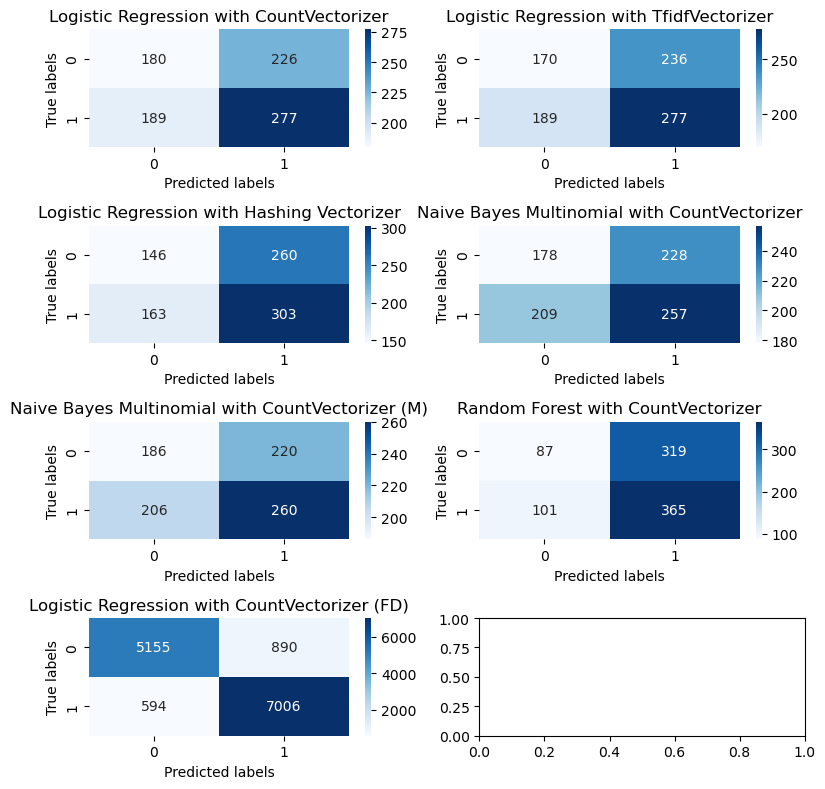

In [400]:
# Create a list of y_test and y_pred for the selected models
y_tests = [y_test_1,
           y_test_2, 
           y_test_3, 
           y_test_4,
           y_test_5,
           y_test_6, 
           y_test_8]
y_preds = [y_pred_Logistic_Regression_Counter_1,
           y_pred_Logistic_Regression_Tfidf_2,
           y_pred_Logistic_Regression_Hashing_3,
           y_pred_Naive_Bayes_Counter_4,
           y_pred_Naive_Bayes_counter_manually_5,
           y_pred_random_forest_counter_6, 
           y_pred_Logistic_Regression_Counter_full_8]

# Create a list of titles for the selected models
titles = ['Logistic Regression with CountVectorizer',  
          'Logistic Regression with TfidfVectorizer',   
          'Logistic Regression with Hashing Vectorizer',
          'Naive Bayes Multinomial with CountVectorizer', 
          'Naive Bayes Multinomial with CountVectorizer (M)',   
          'Random Forest with CountVectorizer',
          'Logistic Regression with CountVectorizer (FD)']

# Create a 4x2 grid of subplots
fig, axs = plt.subplots(nrows=4,
                        ncols=2, 
                        figsize=(8, 8))

# Flatten the grid of subplots
axs = axs.flatten() #

# Loop over all models and plot the confusion matrix as a subplot
for i, (y_test, y_pred) in enumerate(zip(y_tests, y_preds)):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, 
                fmt='d',
                cmap='Blues',
                ax=axs[i])
    
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Predicted labels')
    axs[i].set_ylabel('True labels')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()  #[1]

In [401]:
# EXPLANATION OUTCOME:

***
In the above cell, it is coded a confusion matrix for each of the previus model. For the sake of brevation, I will only read out only the first subplot.

1. Logistic Regression with Counter: there were 180 samples that were truly negative and were correctly classified as negative by the model, while 226 samples that were truly negative were misclassified as positive. Similarly, there were 189 samples that were truly positive and were correctly classified as positive by the model, while 277 samples that were truly positive were misclassified as negative.

In general, it seems that the models are better at predicting positive reviews than negative reviews, as there are more true positives than true negatives in most cases. Models 1-6 have relatively low accuracy and f1-scores, while Models 7 and 8 have much higher accuracy and f1-scores. However, it is important to note that Model 7 (Random Forest with CountVectorizer using the full dataset) has a much higher true positive rate than true negative rate, indicating that it is better at predicting positive reviews than negative reviews. On the other hand, Model 8 (Logistic Regression with CountVectorizer using the full dataset) has a much more balanced true positive and true negative rate, indicating that it is better at predicting both positive and negative reviews.
The confusions matrix provides a detailed breakdown of the performance of all model on the test data which it is used to calculate the F1 score, precision and accuracy. This information can be used to improve the model by adjusting the hyperparameters or collecting more data for certain classes.
###### As a side note:
* precision = true positives / (true positives + false positives)
* recall = true positives / (true positives + false negatives)
* F1-score = 2 * (precision * recall) / (precision + recall)
* Condusion matrix is only for the test results.
***

In [402]:
sentence = "This movie was khvepkalvs and I felt dsfkhbkdvh, and then, cdkjhqsvs."

predicted_sentiment_1 = Logistic_Regression_Counter_1.predict([sentence])[0]
print("Predicted sentiment using Logistic Regression with CountVectorizer:", predicted_sentiment_1)

predicted_sentiment_8 = Logistic_Regression_Counter_full_8.predict([sentence])[0]
print("Predicted sentiment using Logistic Regression with CountVectorizer (FD):", predicted_sentiment_8) 
#[2]

Predicted sentiment using Logistic Regression with CountVectorizer: 1
Predicted sentiment using Logistic Regression with CountVectorizer (FD): 1


***
It appears that the models are more likely to give a positive outcome (i.e., predict a positive review) for the tested reviews, as indicated by the higher true positive rates compared to the true negative rates. This could be due to the fact that the dataset used to train the models may have a higher proportion of positive reviews, and they caused an overfitting on the test.
***

# SECTION VI: EXTRAS
***
In this section, I will provide two types of graphs to visualize the contents of the datasets.
***

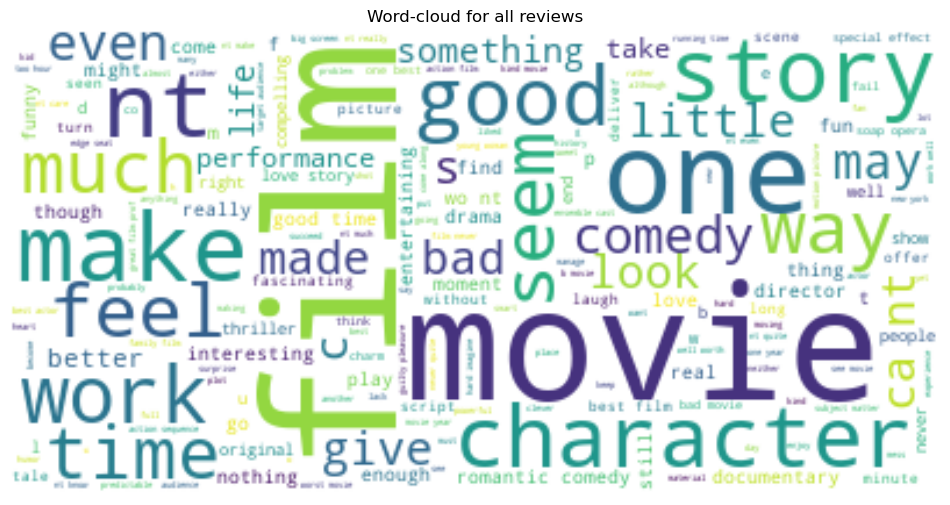

In [403]:
# Combine text from both positive and negative reviews
cloud = df_train['sentence'].to_string(index=False)


wordcloud = WordCloud(background_color="white").generate(cloud)# Generate word-cloud for all reviews.


plt.figure(figsize=(12,8))# Display the word-cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word-cloud for all reviews')
plt.show() #[1]

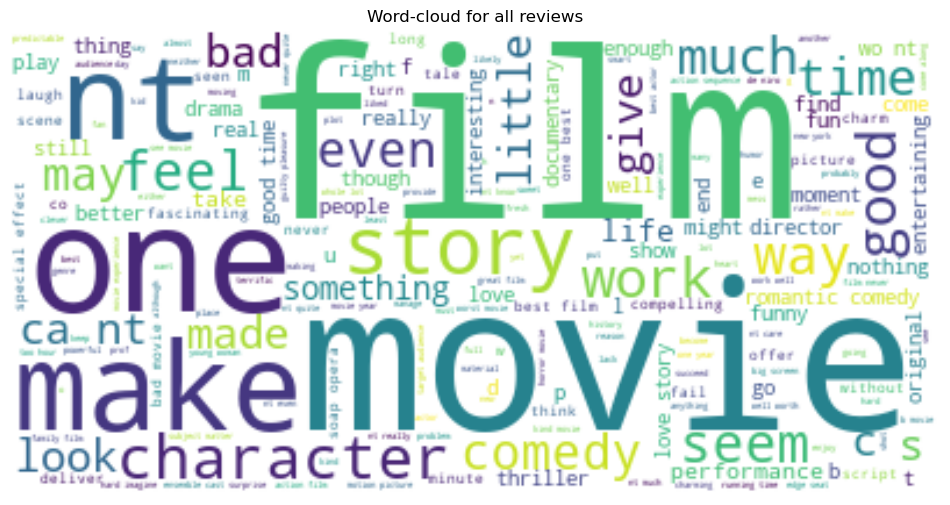

In [404]:
cloud1 = df_train['sentence'].to_string(index=False)
wordcloud = WordCloud(background_color="white").generate(cloud1)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word-cloud for all reviews')
plt.show()

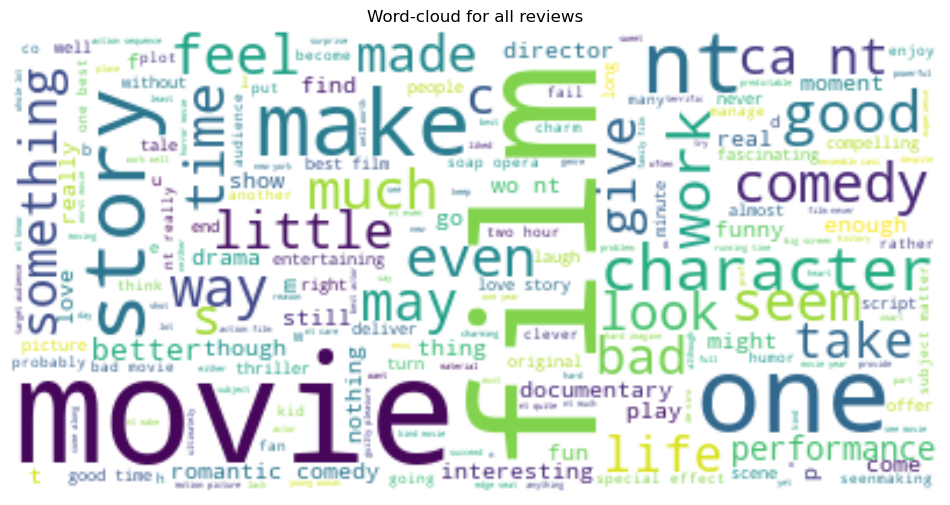

In [405]:
cloud2 = df_full['sentence'].to_string(index=False)
wordcloud = WordCloud(background_color="white").generate(cloud2)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word-cloud for all reviews')
plt.show()

***
The above three visual display the most common words found in the positive and negative reviews of our datasets, pertaining to the subject of movies or films. Further, we observe  terms such as "good," indicating a high level of positve satisfaction, and thus, the higher presence of positive reviews.  Overall, those graphs provides a fascinating visualization.
***

In [406]:
pos = df_train[df_train['sentiment'] == 1]['sentence'] #getting things ready for the plot.
pos1 = df_test[df_test['sentiment'] == 1]['sentence']
pos2 = df_full[df_full['sentiment'] == 1]['sentence']
neg = df_train[df_train['sentiment'] == 0]['sentence']
neg1 = df_test[df_test['sentiment'] == 0]['sentence']
neg2 = df_full[df_full['sentiment'] == 0]['sentence']

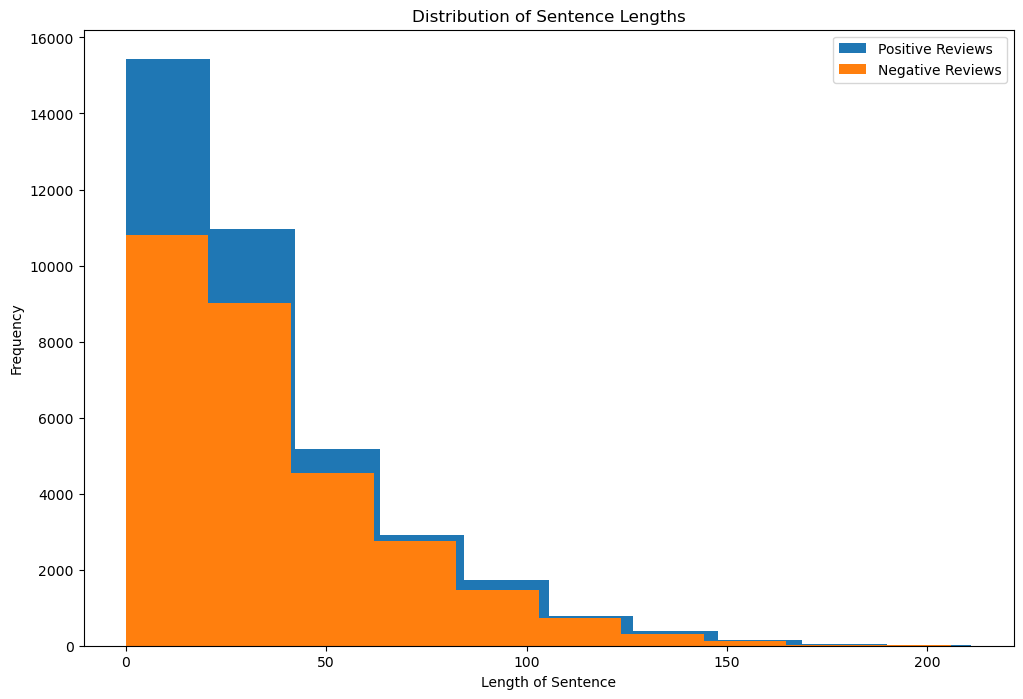

In [407]:
fig, plot = plt.subplots(figsize=(12, 8)) # Set size of 12 by 8 inches

 
plot.hist(pos.str.len(), label='Positive Reviews') #Plot a histogram for positive reviews.
plot.hist(neg.str.len(), label='Negative Reviews') # for negative reviews.


plot.legend(loc='upper right') # legend in the upper right corner

plot.set_xlabel('Length of Sentence') #Set the x-label 

plot.set_ylabel('Frequency') #Set the y-label 
 
plot.set_title('Distribution of Sentence Lengths') #Set the title

plt.show() #Show the plot
#[2]

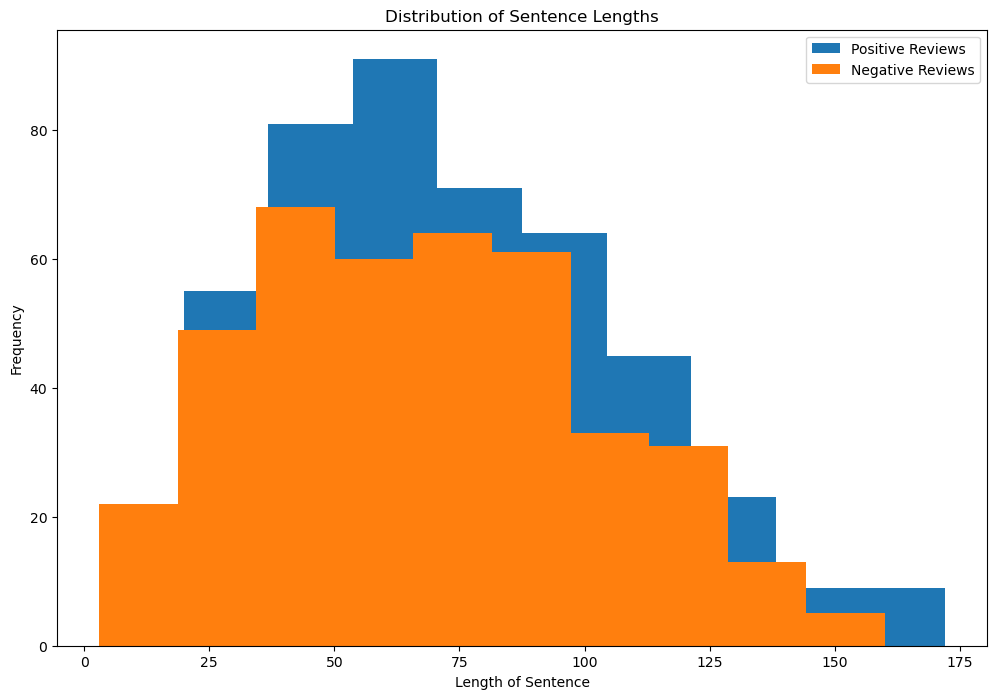

In [408]:
fig, plot1 = plt.subplots(figsize=(12, 8))

plot1.hist(pos1.str.len(), label='Positive Reviews')
plot1.hist(neg1.str.len(), label='Negative Reviews')

plot1.legend(loc='upper right')

plot1.set_xlabel('Length of Sentence')
plot1.set_ylabel('Frequency')
plot1.set_title('Distribution of Sentence Lengths')
plt.show()

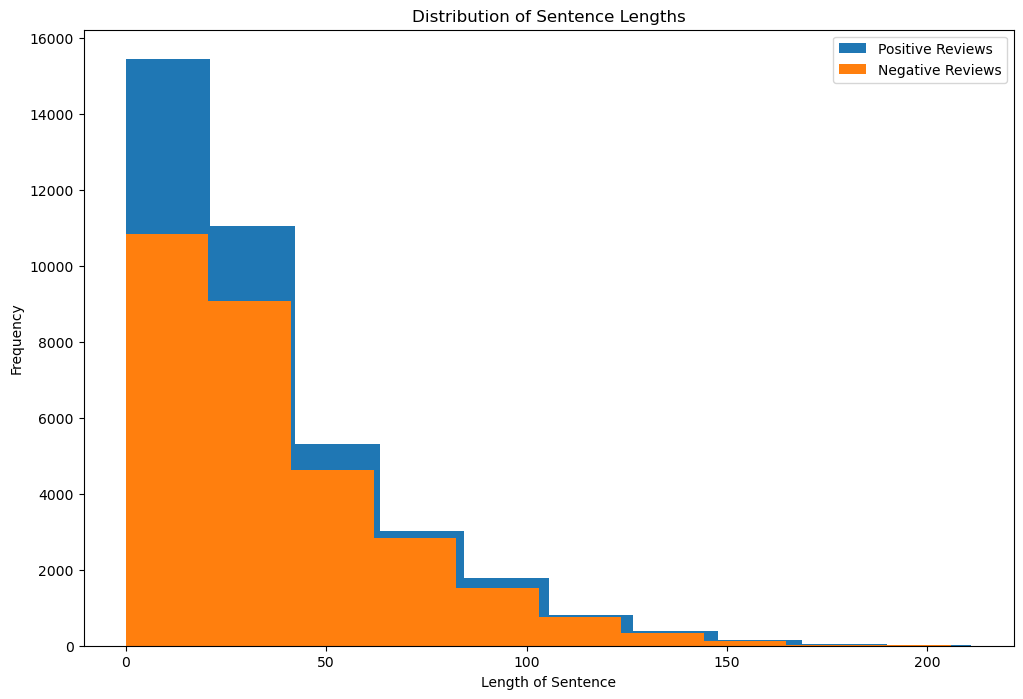

In [409]:
fig, plot2 = plt.subplots(figsize=(12, 8))

plot2.hist(pos2.str.len(), label='Positive Reviews')
plot2.hist(neg2.str.len(), label='Negative Reviews')

plot2.legend(loc='upper right')

plot2.set_xlabel('Length of Sentence')
plot2.set_ylabel('Frequency')
plot2.set_title('Distribution of Sentence Lengths')

plt.show()

***
The three graphs above represent the frequency and length of sentences contained in the database. All of them demonstrate a higher frequency and length of positive reviews, which could potentially lead to issues for the model, such as greater accuracy for positive reviews.
***

# ETHICAL REFLECTION 

***
I was delighted with the outcome of this project. It could be worse. The project's applications are diverse, ranging from social media protection to robot implementation and sales predictions.

Predicting sentiments can be an incredibly challenging task, especially when seemingly harmless words can be utilized to cause harm. This highlights the inadequacy of existing sentiment prediction models in protecting users from hate speech in the context of social media. For instance, the tragic case of an individual taking his own life, in Italy, due to being repeatedly referred to as "the guy with pink trousers" illustrates the insidiousness of hate speech.

Indeed, how can we assign a sentiment score to a word like "fdvkjrnv"? Thus, further research is necessary to develop more effective sentiment prediction models for both user protection and sales predictions. Nonetheless, my project provides a solid foundation for such research but it still needs to improve the project's readability and maintainability, enhancing the flow between codes. 

In conclusion, my project displays a deep commitment to tackling real-world issues and a willingness to experiment with diverse techniques and ideas.
***

# SECTION VI: WORD COUNT

In [410]:
with open('AE2_Coding.ipynb') as f:
    data = json.load(f)
word_count_code = sum(len(line.split()) for cell in data['cells'] if cell['cell_type'] == 'code' for line in cell['source'])
word_count_markdown = sum(len(line.split()) for cell in data['cells'] if cell['cell_type'] == 'markdown' for line in cell['source'] if '#' not in line)
print(f"Word count in code cells: {word_count_code}")
print(f"Word count in markdown cells: {word_count_markdown}")
print(f"Total word count: {word_count_code + word_count_markdown}")

Word count in code cells: 1293
Word count in markdown cells: 1055
Total word count: 2348


# BIBLOGRAPHY CODE

## SECTION I: OVERVIEW DATA

[1] https://www.geeksforgeeks.org/simple-ways-to-read-tsv-files-in-python/

## SECTION II: CLEANING 

[1] https://stackoverflow.com/questions/34293875/how-to-remove-punctuation-marks-from-a-string-in-python-3-x-using-translate 

[2] https://monkeylearn.com/blog/text-cleaning/ 

[3] The structure to return the fuction: https://stackoverflow.com/questions/48965443/clean-text-for-each-sentence-in-python-in-a-for-loop

## SECTION III: TEXT VECTORISATION/MACCHINE LEARING MODEL/HYPER-PARAMETER.

[1] https://www.kaggle.com/getting-started/27261

[2] https://datascience-stackexchange-com.translate.goog/questions/87361/when-should-i-use-fitx-train-and-when-should-i-fit-x-train-y-train?_x_tr_sl=en&_x_tr_tl=it&_x_tr_hl=it&_x_tr_pto=sc

[3] Koliousis, A., & Mylonas, D. (2023). Machine Learning Applications. Northeasten University Lodon [PowerPoint slides]. Slide 22, 5.

[4] https://pandas.pydata.org/docs/reference/api/pandas.concat.html

## SECTION IV: MODEL EXTRAS

[1] Confusion matrix as subplot: https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix

[2] To test the model with a sentence: https://www.youtube.com/watch?v=oXZThwEF4r0

## SECTION V: EXTRAS

[1] Wordcloud: https://www.datacamp.com/tutorial/wordcloud-python

[2] Inspiration histrogram: https://www.southampton.ac.uk/~fangohr/training/python/notebooks/Matplotlib.html

## SECTION VI: WORD COUNT

[1] Inspiration: https://stackoverflow.com/questions/71194571/word-count-of-markdown-cells-in-jupyter-notebook

# BIBLOGRAPHY EXPLANATION

[1] https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html

[2] https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

[3] https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

[4] https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

[5] https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

[6] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html